In [1]:
# Utilities
from pathlib import Path
import os, sys
import subprocess as sp

# Data
import pandas as pd
import numpy as np

# Brain
import nibabel as nb
from nibabel.freesurfer.io import read_annot, read_label, read_morph_data
import cortex
import src.mesh_laplace_sulci
import gdist


# Plotting
from mpl_toolkits import mplot3d
# from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt




## Gdist

In [2]:


# NOTE: had trouble with numba format and jit in surfdist, so some functions are copied over with slight modifications below
# NOTE: fmriprep needs to be run 


def translate_src(src, cortex):
    """
    Convert source nodes to new surface (without medial wall).
    """
    src_new = np.array(np.where(np.in1d(cortex, src))[0], dtype=np.int32)

    return src_new


def triangles_keep_cortex(triangles, cortex):
    """
    Remove triangles with nodes not contained in the cortex label array
    """

    # for or each face/triangle keep only those that only contain nodes within the list of cortex nodes
    input_shape = triangles.shape
    triangle_is_in_cortex = np.all(np.reshape(np.in1d(triangles.ravel(), cortex), input_shape), axis=1)

    cortex_triangles_old = np.array(triangles[triangle_is_in_cortex], dtype=np.int32)

    # reassign node index before outputting triangles
    new_index = np.digitize(cortex_triangles_old.ravel(), cortex, right=True)
    cortex_triangles = np.array(np.arange(len(cortex))[new_index].reshape(cortex_triangles_old.shape), dtype=np.int32)

    return cortex_triangles


def surf_keep_cortex(surf, cortex):
    # split surface into vertices and triangles
    vertices, triangles = surf

    # keep only the vertices within the cortex label
    cortex_vertices = np.array(vertices[cortex], dtype='float64')

    # keep only the triangles within the cortex label
    cortex_triangles = triangles_keep_cortex(triangles, cortex)

    return cortex_vertices, cortex_triangles


def dist_calc_matrix(surf, cortex, label_inds_all):
    cortex_vertices, cortex_triangles = surf_keep_cortex(surf, cortex)
    
    n_labels = len(labels)
    dist_mat = np.zeros((n_labels,n_labels))
    for r1 in np.arange(n_labels):
        #print('r1',r1,label_inds_all[r1])
        for r2 in np.arange(n_labels):
            #print('r2',r2,label_inds_all[r2])
            #val1 = gdist.compute_gdist(cortex_vertices, cortex_triangles,
            #                                source_indices = array(label_inds_all[r1]))
            #print('val1',val1)

            val2 = gdist.compute_gdist(cortex_vertices, cortex_triangles,
                                            source_indices = np.array(label_inds_all[r1]),
                                            target_indices = np.array(label_inds_all[r2]))
            #print('val2',val2)
            dist_mat[r1,r2] = np.amin(val2)

    return dist_mat


def getLabelIndices(sub,hemi,labels,cortex):
    label_inds_all = []

    n_labels = len(labels)
    for l in arange(n_labels):
        if type(labels[l]) is list: # pick the first label in list that exits
            label_found = False
            for lab in labels[l]:
                labelfile = '%s/sub-%s/label/%s.%s.label'%(os.environ['SUBJECTS_DIR'],sub,hemi,lab)
                if os.path.exists(labelfile) and not label_found:
                    labelfile_use = labelfile
                    label_found = True
        else: # look for specific label
            labelfile_use = '%s/sub-%s/label/%s.%s.label'%(os.environ['SUBJECTS_DIR'],sub,hemi,labels[l])
        label_inds = nb.freesurfer.io.read_label(labelfile_use, read_scalars=False)
        label_inds_t = translate_src(label_inds,cortex) # exclude medial wall
        label_inds_all.append(label_inds_t)
    
    return label_inds_all


def getDistMatrix(fmriprep_derivatives_dir,annot_file,sub,hemi,savedir):
    highres_surface = '%s/sub-%s/ses-%s/anat/sub-%s_ses-%s_hemi-%s_midthickness.surf.gii'%(fmriprep_derivatives_dir,sub,sub[-1],sub,sub[-1],hemi[0].upper())
    giidata = nb.load(highres_surface)
    giidata2 = np.squeeze(np.asarray([x.data for x in giidata.darrays])) 
    surf = (giidata2[0],giidata2[1])  

    cort_file = '%s/sub-%s/label/%s.cortex.label'%(os.environ['SUBJECTS_DIR'],sub,hemi)
    cortex = np.sort(nb.freesurfer.read_label(cort_file))

    label_inds_all = getLabelIndices(sub,hemi,labels,cortex)

    dist_matrix = dist_calc_matrix(surf,cortex,label_inds_all)
    print('dist_matrix',dist_matrix)

    np.savetxt('%s/adj-labels-%s.txt'%(savedir,hemi),dist_matrix)

## Find boundary

In [3]:



def read_label(label_name):
    """
    Reads a freesurfer-style .label file (5 columns)
    
    Parameters
    ----------
    label_name: str 
    
    Returns 
    -------
    vertices: index of the vertex in the label np.array [n_vertices] 
    RAS_coords: columns are the X,Y,Z RAS coords associated with vertex number in the label, np.array [n_vertices, 3] 
    
    """
    
    # read label file, excluding first two lines of descriptor 
    df_label = pd.read_csv(label_name,skiprows=[0,1],header=None,names=['vertex','x_ras','y_ras','z_ras','stat'],delimiter='\s+')
    
    vertices = np.array(df_label.vertex) 
    RAS_coords = np.empty(shape = (vertices.shape[0], 3))
    RAS_coords[:,0] = df_label.x_ras
    RAS_coords[:,1] = df_label.y_ras
    RAS_coords[:,2] = df_label.z_ras
    
    return vertices, RAS_coords



In [4]:
## Load labels for boundary sulci


vertices, coords = read_label('~/Desktop/cnl/subjects/100307/label/lh.MCGS.label')
label_MCGS = read_label('~/Desktop/cnl/subjects/100307/label/lh.MCGS.label')

r_data = np.array([ras[0] for ras in coords])
a_data = np.array([ras[1] for ras in coords])
s_data = np.array([ras[2] for ras in coords])




In [37]:
def find_inferior_boundary(read_label, outlier_corrected=True, decimal_size=1, outlier_std_threshold=3):
    """
    Finds vertices along inferior boundary of given Freesurfer label.

    Bins all vertices along anterior axis, effecitvly getting every vertex in a coronal slice rounded to the decimal_size,
    and returns coordinates with the lowest Superior axis value in that column.

    INPUT:
    read_label = list [vertices, coordinates] : as outputed from read_label
    outlier_corrected = boolean; if True removes all vertices if S value is outside of 3 SDs of mean
    decimal_size = int; determines size of rounding done to bin anterior vertices, 1 is suggested
    outlier_std_threshold= int; allows change of SD multiple for outlier correction

    OUTPUT:
    inferior_boundary_vertex_num = np array; vertex number for each minimum Superior value along anterior axis
    inferior_boundary_coords = np array; RAS coordinates for each minimum Superior value along anterior axis


    Example:

    output_vertex_number, output_vertex_coords = find_inferior_boundary(read_label('home/subjects/100307/label/lh.MCGS.label'))


    """
  
    vertex_num = read_label[0]
    ras_coords = read_label[1]

    
    r_data = np.array([ras[0] for ras in ras_coords])
    a_data = np.array([ras[1] for ras in ras_coords])
    s_data = np.array([ras[2] for ras in ras_coords])

    inferior_boundary_coords = []
    inferior_boundary_vertex_num = []
    rounded_anterior = np.round(a_data, decimals=decimal_size)

  # for each rounded A value, find the vertex with the lowest S value
  # add vertex to inferior boundary
    for anterior in np.unique(rounded_anterior):
      # get all vertices with shared A coordinate
      column_idx = np.where(rounded_anterior == anterior)[0]
      # find minimum S coordinate from that column of points
      min_val = np.amin(s_data[column_idx])
      # be sure idx is drawn from original column idxes
      all_min_idx = np.where(s_data == min_val)[0]
      column_min_idx = np.intersect1d(all_min_idx, column_idx)
      # add inferior boundary and vertex to list

      inferior_boundary_coords.append(list(ras_coords[column_min_idx][0]))
      inferior_boundary_vertex_num.append(vertex_num[column_min_idx][0])

    mean_boundary_coord = np.mean([i[2] for i in inferior_boundary_coords])
    std_boundary_coord = np.std([i[2] for i in inferior_boundary_coords])
    
    # Keep coordinate if S coordinate is within 3 stds of mean 
    if outlier_corrected == True:
      inferior_boundary_coords_outlier = []
      inferior_boundary_vertex_num_outlier = []
      for i, coord_vert in enumerate(inferior_boundary_coords):
          if coord_vert[2] > (mean_boundary_coord - decimal_size * std_boundary_coord) and coord_vert[2] < (mean_boundary_coord + decimal_size * std_boundary_coord): 
            inferior_boundary_coords_outlier.append(inferior_boundary_coords[i])
            inferior_boundary_vertex_num_outlier.append(inferior_boundary_vertex_num[i])
          else:
            pass
      return np.array(inferior_boundary_vertex_num_outlier), np.array(inferior_boundary_coords_outlier)
    else: 
      pass
#     for vertex in ras_coords:
      return np.array(inferior_boundary_vertex_num), np.array(inferior_boundary_coords)


vert_num, verts = find_inferior_boundary([vertices, coords], outlier_corrected=False, decimal_size=1)

r_data_min_inferior = np.array([ras[0] for ras in verts])
a_data_min_inferior = np.array([ras[1] for ras in verts])
s_data_min_inferior = np.array([ras[2] for ras in verts])



In [38]:
def find_posterior_boundary(read_label, outlier_corrected=True, decimal_size=1, outlier_std_threshold=3):
    """
    Finds vertices along posterior boundary of given Freesurfer label.

    Bins all vertices along superior axis, effecitvly getting every vertex in a horizontal slice rounded to the decimal_size,
    and returns coordinates with the lowest superior axis value in that column.

    INPUT:
    read_label = list [vertices, coordinates] : as outputed from read_label
    outlier_corrected = boolean; if True removes all vertices if S value is outside of 3 SDs of mean
    decimal_size = int; determines size of rounding done to bin superior vertices, 1 is suggested
    outlier_std_threshold= int; allows change of SD multiple for outlier correction

    OUTPUT:
    posterior_boundary_vertex_num = np array; vertex number for each minimum Superior value along superior axis
    posterior_boundary_coords = np array; RAS coordinates for each minimum Superior value along superior axis


    Example:

    output_vertex_number, output_vertex_coords = find_posterior_boundary(read_label('home/subjects/100307/label/lh.MCGS.label'))


    """
  
    vertex_num = read_label[0]
    ras_coords = read_label[1]

    
    r_data = np.array([ras[0] for ras in ras_coords])
    a_data = np.array([ras[1] for ras in ras_coords])
    s_data = np.array([ras[2] for ras in ras_coords])

    posterior_boundary_coords = []
    posterior_boundary_vertex_num = []
    rounded_superior = np.round(s_data, decimals=decimal_size)

  # for each rounded A value, find the vertex with the lowest S value
  # add vertex to posterior boundary
    for superior in np.unique(rounded_superior):
      # get all vertices with shared A coordinate
      column_idx = np.where(rounded_superior == superior)[0]
      # find minimum S coordinate from that column of points
      min_val = np.amin(s_data[column_idx])
      # be sure idx is drawn from original column idxes
      all_min_idx = np.where(s_data == min_val)[0]
      column_min_idx = np.intersect1d(all_min_idx, column_idx)
      # add posterior boundary and vertex to list

      posterior_boundary_coords.append(list(ras_coords[column_min_idx][0]))
      posterior_boundary_vertex_num.append(vertex_num[column_min_idx][0])
      

    mean_boundary_coord = np.mean([i[1] for i in posterior_boundary_coords])
    std_boundary_coord = np.std([i[1] for i in posterior_boundary_coords])
    
    # Keep coordinate if S coordinate is within 3 stds of mean 
    if outlier_corrected == True:
      posterior_boundary_coords_outlier = []
      posterior_boundary_vertex_num_outlier = []
      for i, coord_vert in enumerate(posterior_boundary_coords):
          if coord_vert[1] > (mean_boundary_coord - decimal_size * std_boundary_coord) and coord_vert[1] < (mean_boundary_coord + decimal_size * std_boundary_coord): 
            posterior_boundary_coords_outlier.append(posterior_boundary_coords[i])
            posterior_boundary_vertex_num_outlier.append(posterior_boundary_vertex_num[i])
          else:
            pass
      return np.array(posterior_boundary_vertex_num_outlier), np.array(posterior_boundary_coords_outlier)
    else: 
      pass
#     for vertex in ras_coords:
      return np.array(posterior_boundary_vertex_num), np.array(posterior_boundary_coords)



In [39]:
vert_num, verts = find_posterior_boundary([vertices, coords], outlier_corrected=True, decimal_size=1)

r_data_min_posterior = np.array([ras[0] for ras in verts])
a_data_min_posterior = np.array([ras[1] for ras in verts])
s_data_min_posterior = np.array([ras[2] for ras in verts])

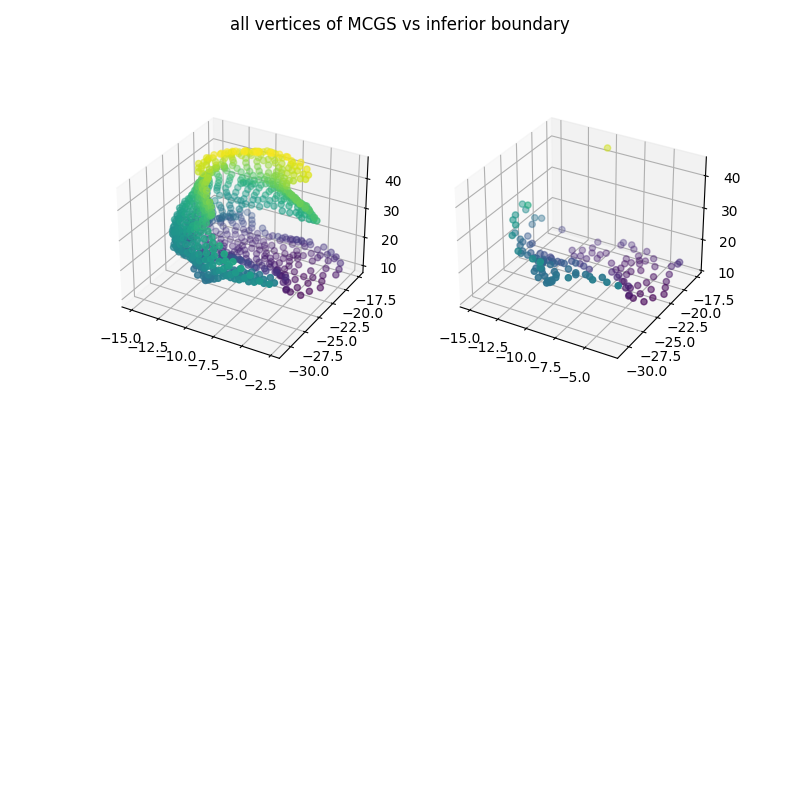

In [40]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax1.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

# Getting lower bound of the sulcus

ax2.scatter3D(r_data_min_inferior, a_data_min_inferior, s_data_min_inferior, cmap='viridis', c=s_data_min_inferior, vmin=10, vmax=45)
ax2.set(zlim3d=[10,45]);
plt.suptitle('all vertices of MCGS vs inferior boundary')
plt.show();


# ax3 = fig.add_subplot(223, projection='3d')
# ax4 = fig.add_subplot(224, projection='3d')
# ax3.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

# # Getting lower bound of the sulcus

# ax4.scatter3D(r_data_min_posterior, a_data_min_posterior, s_data_min_posterior, cmap='viridis', c=s_data_min_posterior, vmin=10, vmax=45)
# ax4.set(zlim3d=[10,45])
# plt.suptitle('all vertices of MCGS vs boundary vertices')
# fig.show();


In [32]:
def find_boundary_vertices(boundary, read_label, outlier_corrected=True, decimal_size=1, outlier_std_threshold=3):
    """
    Finds vertices along posterior boundary of given Freesurfer label.

    Bins all vertices along boundary axis, effecitvly getting every vertex in a horizontal slice rounded to the decimal_size,
    and returns coordinates with the lowest superior axis value in that column.

    INPUT:
    read_label = list [vertices, coordinates] : as outputed from read_label
    outlier_corrected = boolean; if True removes all vertices if S value is outside of 3 SDs of mean
    decimal_size = int; determines size of rounding done to bin superior vertices, 1 is suggested
    outlier_std_threshold= int; allows change of SD multiple for outlier correction

    OUTPUT:
    posterior_boundary_vertex_num = np array; vertex number for each minimum Superior value along superior axis
    posterior_boundary_coords = np array; RAS coordinates for each minimum Superior value along superior axis


    Example:

    output_vertex_number, output_vertex_coords = find_posterior_boundary(read_label('home/subjects/100307/label/lh.MCGS.label'))


    """
    if boundary == 'anterior' or boundary == 'posterior':
      # orthogonal measure index is the index along which we are trying to find min values i.e. A for S
      # finding minimum values on boundary axis along orthogonal axis
      measure_idx = 1
      orthogonal_measure_idx = 2

    if boundary == 'inferior' or boundary == 'superior':
      measure_idx = 2
      orthogonal_measure_idx = 1
    

    vertex_num = read_label[0]
    ras_coords = read_label[1]

    r_data = np.array([ras[0] for ras in ras_coords])
    a_data = np.array([ras[1] for ras in ras_coords])
    s_data = np.array([ras[2] for ras in ras_coords])
    
    all_data = [r_data, a_data, s_data]
    measure_data = all_data[measure_idx]
    orthogonal_data = all_data[orthogonal_measure_idx]
    
    
    boundary_coords = []
    boundary_vertex_num = []
    rounded_orthogonal = np.round(orthogonal_data, decimals=decimal_size)

  # for each rounded A value, find the vertex with the lowest S value
  # add vertex to posterior boundary

    for orthogonal_edge in np.unique(rounded_orthogonal):
      # get all vertices with shared orthogonal coordinate
      column_idx = np.where(rounded_orthogonal == orthogonal_edge)[0]

      # find minimum coordinate from that column of points
      if boundary == 'anterior' or boundary == 'inferior':
        min_val = np.amin(measure_data[column_idx])
        # be sure idx is drawn from original column idxes
        all_min_idx = np.where(measure_data == min_val)[0]
        column_min_idx = np.intersect1d(all_min_idx, column_idx)
        # add boundary and vertex to list
        boundary_coords.append(list(ras_coords[column_min_idx][0]))
        boundary_vertex_num.append(vertex_num[column_min_idx][0])
        
      else:
        max_val = np.amax(measure_data[column_idx])
        # be sure idx is drawn from original column idxes
        all_max_idx = np.where(measure_data == max_val)[0]
        column_max_idx = np.intersect1d(all_max_idx, column_idx)
        # add posterior boundary and vertex to list
        boundary_coords.append(list(ras_coords[column_max_idx][0]))
        boundary_vertex_num.append(vertex_num[column_max_idx][0])
      

    mean_boundary_coord = np.mean([i[measure_idx] for i in boundary_coords])
    std_boundary_coord = np.std([i[measure_idx] for i in boundary_coords])
    
    # Keep coordinate if coordinate is within 3 stds of mean 
    if outlier_corrected == True:
      boundary_coords_outlier = []
      boundary_vertex_num_outlier = []
      for i, coord_vert in enumerate(boundary_coords):
          if coord_vert[measure_idx] > (mean_boundary_coord - decimal_size * std_boundary_coord) and coord_vert[measure_idx] < (mean_boundary_coord + decimal_size * std_boundary_coord): 
            boundary_coords_outlier.append(boundary_coords[i])
            boundary_vertex_num_outlier.append(boundary_vertex_num[i])
          else:
            pass
      return np.array(boundary_vertex_num_outlier), np.array(boundary_coords_outlier)
    else: 
      pass
#     for vertex in ras_coords:
      return np.array(boundary_vertex_num), np.array(boundary_coords)



In [59]:
test_vert_num, test_verts = find_boundary_vertices(boundary='anterior', read_label=label_MCGS, outlier_corrected=True, decimal_size=1)

test_r_data_min_inferior = np.array([ras[0] for ras in test_verts])
test_a_data_min_inferior = np.array([ras[1] for ras in test_verts])
test_s_data_min_inferior = np.array([ras[2] for ras in test_verts])



Text(0.5, 0.98, 'all vertices of MCGS vs inferior boundary')

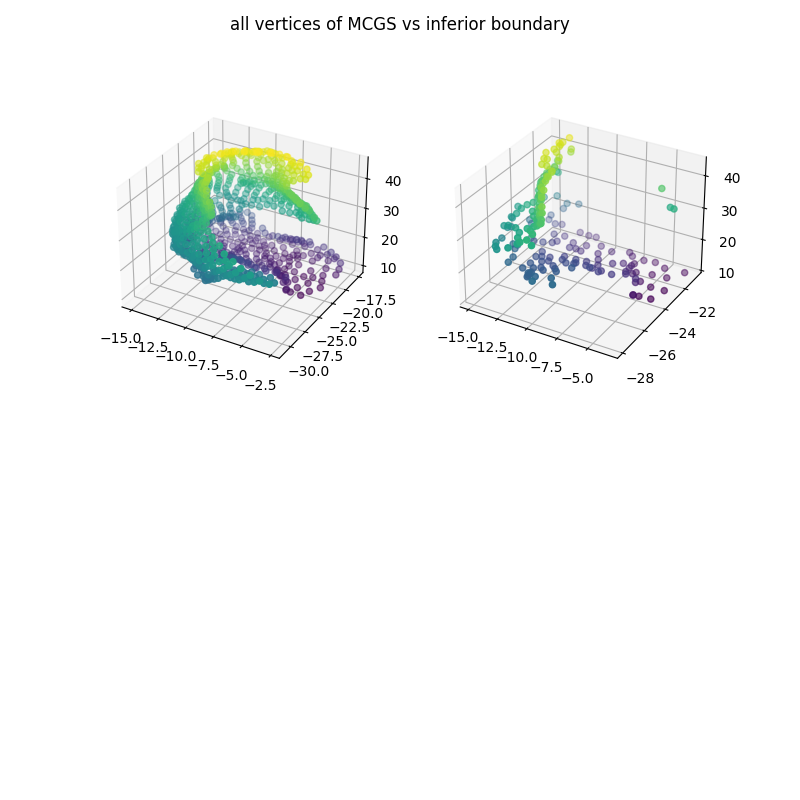

In [60]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax1.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

# Getting lower bound of the sulcus

ax2.scatter3D(test_r_data_min_inferior, test_a_data_min_inferior, test_s_data_min_inferior, cmap='viridis', c=test_s_data_min_inferior, vmin=10, vmax=45)
ax2.set(zlim3d=[10,45]);
plt.suptitle('all vertices of MCGS vs inferior boundary')

## Surfaces and cutting

In [97]:
test_sub = Scalpel_Surface(subject_filepath='~/Desktop/cnl/subjects/100307')

In [98]:
test_sub.cortex
        

[(array([     0,      1,      2, ..., 130876, 130877, 130878]),
  array([[ -9.776, -20.321,  76.679],
         [-10.099, -20.284,  76.59 ],
         [ -9.904, -20.546,  76.561],
         ...,
         [ -5.2  , -31.194, -58.268],
         [ -5.154, -31.042, -58.757],
         [ -5.067, -31.108, -56.459]])),
 (array([     0,      1,      2, ..., 128343, 128344, 128345]),
  array([[ 14.312, -11.837,  74.144],
         [ 13.963, -11.905,  74.312],
         [ 13.608, -12.006,  74.401],
         ...,
         [ 15.207, -29.5  , -75.687],
         [ 15.03 , -30.054, -75.609],
         [ 14.744, -30.239, -75.701]]))]

## Class Definition

In [96]:
# Use boundary sulci to capture all vertices in surface between boundaries, and plot

class Scalpel_Surface:
    def  __init__(self, subject_filepath=''):
        self.subject_filepath = Path(subject_filepath)
        self.cortex = [read_label(self.subject_filepath / 'label/lh.cortex.label'), read_label(self.subject_filepath / 'label/rh.cortex.label')]
        
    
    def get_boundary(self, hemi, anterior_label, posterior_label, inferior_label, superior_label):
        # Outputs dict of boundary vertices for all boundary labels
        anterior_boundary_vertices, anterior_boundary_vertex_num = find_boundary_vertices(hemi=hemi, boundary='anterior', read_label=anterior_label, outlier_corrected=True, decimal_size=1)
        posterior_boundary_vertices, posterior_boundary_vertex_num = find_boundary_vertices(hemi=hemi,boundary='posterior', read_label=posterior_label, outlier_corrected=True, decimal_size=1)
        inferior_boundary_vertices, inferior_boundary_vertex_num = find_boundary_vertices(hemi=hemi,boundary='inferior', read_label=inferior_label, outlier_corrected=True, decimal_size=1)
        superior_boundary_vertices, superior_boundary_vertex_num = find_boundary_vertices(hemi=hemi,boundary='superior', read_label=superior_label, outlier_corrected=True, decimal_size=1)

        boundary_dict = {'anterior' : [anterior_boundary_vertices, anterior_boundary_vertex_num],
                         'posterior' : [posterior_boundary_vertices, posterior_boundary_vertex_num],
                         'inferior' : [inferior_boundary_vertices, inferior_boundary_vertex_num ],
                         'superior' : [superior_boundary_vertices, superior_boundary_vertex_num]}
        return boundary_dict
    
    def make_ROI_cut(self, hemi, anterior_label, posterior_label, inferior_label, superior_label, ROI_name=''):
        # Makes label of entire ROI between boundary vertices
        boundary_verts = self.get_boundary(anterior_label, posterior_label, inferior_label, superior_label)
        
        # get vertex indices for all within ROI
        # for hemi in self.cortex:
        #     for vertex in hemi:
        #         if 
        

    def plot_boundary(self, label_name='label', label_filepath='', outlier_corrected_bool=True, boundary_type='anterior', decimal_size=1):
        # Plot boundary versus original label
        vertices, coords = read_label(label_filepath)
        
        r_data = np.array([ras[0] for ras in coords])
        a_data = np.array([ras[1] for ras in coords])
        s_data = np.array([ras[2] for ras in coords])

        boundary_vert_num, boundary_verts = find_boundary_vertices(boundary=boundary_type, read_label=[vertices, coords], outlier_corrected=outlier_corrected_bool, decimal_size=decimal_size)

        boundary_r_data = np.array([ras[0] for ras in boundary_verts])
        boundary_a_data = np.array([ras[1] for ras in boundary_verts])
        boundary_s_data = np.array([ras[2] for ras in boundary_verts])

        fig = plt.figure(figsize=(8,8))
        ax1 = fig.add_subplot(221, projection='3d')
        ax2 = fig.add_subplot(222, projection='3d')
        ax1.scatter3D(r_data, a_data, s_data, cmap='viridis', c=s_data)

        # Getting lower bound of the sulcus

        ax2.scatter3D(boundary_r_data, boundary_a_data, boundary_s_data, cmap='viridis', c=boundary_s_data, vmin=10, vmax=45)
        ax2.set(zlim3d=[10,45]);
        plt.suptitle(f'all vertices of {label_name} vs {boundary_type} boundary')
        plt.show;





In [ ]:

def find_boundary_vertices(subject_filepath, hemi, label_name, boundary_type, outlier_corrected=True, decimal_size=1, outlier_std_threshold=3):
    """
    Finds vertices along boundary of given Freesurfer label, as identified by boundary_type.

    Bins all vertices along boundary axis, effectively getting every vertex in a slice rounded to the decimal_size,
    and returns coordinates and vertex numbers with the minimum or maximum axis value as specified by boundary type.

    INPUT:
    label_name = string : as it appears in /label/ freesurfer directory ie MCGS for lh.MCGS.label
    outlier_corrected = boolean; if True removes all vertices if S value is outside of 3 SDs of mean
    decimal_size = int; determines size of rounding done to bin superior vertices, 1 is suggested
    outlier_std_threshold= int; allows change of SD multiple for outlier correction

    OUTPUT:
    boundary_vertex_num = np array; vertex number for each minimum Superior value along superior axis
    boundary_coords = np array; RAS coordinates for each minimum Superior value along superior axis


    Example:

    output_vertex_number, output_vertex_coords = find_boundary_vertices(subject_filepath='~/subjects/100206/', hemi='lh', label_name='MCGS', boundary_type='anterior')


    """
    if boundary_type == 'anterior' or boundary_type == 'posterior':
      # orthogonal measure index is the index along which we are trying to find min values i.e. A for S
      # finding minimum values on boundary_type axis along orthogonal axis
      measure_idx = 1
      orthogonal_measure_idx = 2

    if boundary_type == 'inferior' or boundary_type == 'superior':
      measure_idx = 2
      orthogonal_measure_idx = 1
    
    label_data = read_label(subject_filepath / f"label/{hemi}.{label_name}.label")

    vertex_num = label_data[0]
    ras_coords = label_data[1]

    r_data = np.array([ras[0] for ras in ras_coords])
    a_data = np.array([ras[1] for ras in ras_coords])
    s_data = np.array([ras[2] for ras in ras_coords])
    
    all_data = [r_data, a_data, s_data]
    measure_data = all_data[measure_idx]
    orthogonal_data = all_data[orthogonal_measure_idx]
    
    
    boundary_coords = []
    boundary_vertex_num = []
    rounded_orthogonal = np.round(orthogonal_data, decimals=decimal_size)

  # for each rounded A value, find the vertex with the lowest S value
  # add vertex to posterior boundary

    for orthogonal_edge in np.unique(rounded_orthogonal):
      # get all vertices with shared orthogonal coordinate
      column_idx = np.where(rounded_orthogonal == orthogonal_edge)[0]

      # find minimum coordinate from that column of points
      if boundary_type == 'anterior' or boundary_type == 'inferior':
        min_val = np.amin(measure_data[column_idx])
        # be sure idx is drawn from original column idxes
        all_min_idx = np.where(measure_data == min_val)[0]
        column_min_idx = np.intersect1d(all_min_idx, column_idx)
        # add boundary and vertex to list
        boundary_coords.append(list(ras_coords[column_min_idx][0]))
        boundary_vertex_num.append(vertex_num[column_min_idx][0])
        
      else:
        max_val = np.amax(measure_data[column_idx])
        # be sure idx is drawn from original column idxes
        all_max_idx = np.where(measure_data == max_val)[0]
        column_max_idx = np.intersect1d(all_max_idx, column_idx)
        # add posterior boundary and vertex to list
        boundary_coords.append(list(ras_coords[column_max_idx][0]))
        boundary_vertex_num.append(vertex_num[column_max_idx][0])
      

    mean_boundary_coord = np.mean([i[measure_idx] for i in boundary_coords])
    std_boundary_coord = np.std([i[measure_idx] for i in boundary_coords])
    
    # Keep coordinate if coordinate is within 3 stds of mean 
    if outlier_corrected == True:
      boundary_coords_outlier = []
      boundary_vertex_num_outlier = []
      for i, coord_vert in enumerate(boundary_coords):
          if coord_vert[measure_idx] > (mean_boundary_coord - decimal_size * std_boundary_coord) and coord_vert[measure_idx] < (mean_boundary_coord + decimal_size * std_boundary_coord): 
            boundary_coords_outlier.append(boundary_coords[i])
            boundary_vertex_num_outlier.append(boundary_vertex_num[i])
          else:
            pass
      return np.array(boundary_vertex_num_outlier), np.array(boundary_coords_outlier)
    else: 
      pass
#     for vertex in ras_coords:
      return np.array(boundary_vertex_num), np.array(boundary_coords)



## Pycortex

In [ ]:

# project_dir = Path('/Users/benparker/Desktop/cnl/CNL_scalpel/results/')
# subjects_dir = Path('/Users/benparker/Desktop/cnl/subjects/')
# subjects_dir_str = '/Users/benparker/Desktop/cnl/subjects/'

# ## read_annot returns [0] labels at each vertex, -1 for no id [1]: ctab [2]: label names 
# annot_verts, annot_ctab, annot_names = read_annot(subjects_dir / '100307/label/rh.aparc.a2009s.annot')


# # import test subject to pycortex db
# cortex.freesurfer.import_subj('100307', freesurfer_subject_dir=subjects_dir_str, whitematter_surf='white')


In [ ]:


## split FC map by boundary sulci

##### ID vertices within boundary by [0] from read annot